In [1]:
! pip install pennylane
! pip install qiskit
! pip install pennylane-qiskit

import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse

from scipy import misc
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
from sklearn.decomposition import PCA
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from skimage import io
import torchvision.datasets.mnist as mnist
from PIL import Image


In [3]:
BATCH_SIZE = 32
epochs = 1
lr = 1e-3
w_decay = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def data_prepare(data_label, DOWNLOAD_MNIST=True):
    # Mnist digits dataset
    if not (os.path.exists("./dataset/")) or not os.listdir("./dataset/"):
        DOWNLOAD_MNIST = True

    train_data = torchvision.datasets.MNIST(
        root="./dataset/",
        train=True,  # this is training data
        transform=torchvision.transforms.ToTensor(),  # Converts a PIL.Image or numpy.ndarray to
        download=DOWNLOAD_MNIST)

    root = "./dataset/MNIST/raw"
    train_set = (
        mnist.read_image_file(os.path.join(root, 'train-images-idx3-ubyte')),
        mnist.read_label_file(os.path.join(root, 'train-labels-idx1-ubyte')))

    data = []
    for i, (img, label) in enumerate(zip(train_set[0], train_set[1])):
        if label == data_label:
            data.append(img.numpy()/255)
    return data


data = np.array(data_prepare(data_label=0))
data = data.reshape(data.shape[0], data.shape[1]*data.shape[2])

# --------------------------------------------------
# ---------------- PCA Section ---------------------
# --------------------------------------------------
k=2
pca = PCA(n_components=k) # k represents the number of return
pca.fit(data)
pca_data = pca.transform(data)
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()



pca_data_rot= np.arcsin(np.sqrt(pca_data))
# --------------------------------------------------
# Define a function that can take in PCA'ed data and return an image
# --------------------------------------------------
def descale_points(d_point,scales=pca_descaler,tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:,col] *= scales[col][1]
        d_point[:,col] += scales[col][0]
    # print("dasdasdasdasd", d_point)
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction
# --------------------------------------------------------------------------------------------------------------------------------------------------------------

n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):


    qml.RY(inputs[0], wires=1)
    qml.RY(inputs[1], wires=2)

    qml.RY(inputs[2], wires=3)
    qml.RY(inputs[3], wires=4)

    qml.RX(w000, wires=1)
    qml.RX(w001, wires=2)

    qml.RY(w008, wires=1)
    qml.RY(w009, wires=2)

    qml.RZ(w016, wires=1)
    qml.RZ(w017, wires=2)
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,1])

    qml.RX(w200, wires=1)
    qml.RX(w201, wires=2)

    qml.RY(w208, wires=1)
    qml.RY(w209, wires=2)

    qml.RZ(w216, wires=1)
    qml.RZ(w217, wires=2)
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,1])

    # swap test
    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(0)

    return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

# ----------------------------------------------------------------------model-----------------------------------------------------------------------------------
class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model = MNIST().to(device)
# ----------------------------------------------------------------training function-----------------------------------------------------------------------------
class Logloss(nn.Module):
    def __init__(self):
        super(Logloss, self).__init__()
    def forward(self, output):
        return torch.mean(-torch.log(output[0]))

def train(model, device, optimizer, epoch):
    data = []
    running_loss = 0.0
    output_sum = 0.0
    loss_sum = 0.0
    for i in range(len(pca_data)):
        noise = torch.empty(2, dtype=torch.float32).uniform_(0.3,0.9).to(device)
        inputs = torch.Tensor(pca_data_rot[i]).to(device)
        inputs = torch.cat((noise, inputs), 0)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_function = Logloss()
        loss = loss_function(outputs)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        running_loss += loss.item()
        output_sum += outputs
        if (i+1) % 100 == 0:
            print('epoch: %d, loss: %.3f' % (epoch, running_loss / 100))
            running_loss = 0.0
    this_epoch_loss = loss_sum/len(pca_data)
    this_epoch_output = output_sum/len(pca_data)
    return this_epoch_loss, this_epoch_output

# --------------------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------main----------------------------------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []
test_output = []
for epoch in range(epochs):
    a, b = train(model, device, optimizer, epoch)
    loss_list.append(a)
    output_list.append(b)
    torch.save(model.state_dict(), './2gan_1.pth')
    # torch.save(model.state_dict(), './hh.pth')
    print("loss list is:", loss_list)
    print("output list is:",output_list)




epoch: 0, loss: 0.551
epoch: 0, loss: 0.486
epoch: 0, loss: 0.435
epoch: 0, loss: 0.390
epoch: 0, loss: 0.361
epoch: 0, loss: 0.299
epoch: 0, loss: 0.251
epoch: 0, loss: 0.191
epoch: 0, loss: 0.142
epoch: 0, loss: 0.102
epoch: 0, loss: 0.076
epoch: 0, loss: 0.051
epoch: 0, loss: 0.048
epoch: 0, loss: 0.040
epoch: 0, loss: 0.030
epoch: 0, loss: 0.026
epoch: 0, loss: 0.025
epoch: 0, loss: 0.023
epoch: 0, loss: 0.022
epoch: 0, loss: 0.027
epoch: 0, loss: 0.025
epoch: 0, loss: 0.025
epoch: 0, loss: 0.029
epoch: 0, loss: 0.026
epoch: 0, loss: 0.025
epoch: 0, loss: 0.023
epoch: 0, loss: 0.020
epoch: 0, loss: 0.022
epoch: 0, loss: 0.024
epoch: 0, loss: 0.022
epoch: 0, loss: 0.024
epoch: 0, loss: 0.026
epoch: 0, loss: 0.022
epoch: 0, loss: 0.023
epoch: 0, loss: 0.028
epoch: 0, loss: 0.021
epoch: 0, loss: 0.023
epoch: 0, loss: 0.022
epoch: 0, loss: 0.024
epoch: 0, loss: 0.023
epoch: 0, loss: 0.026
epoch: 0, loss: 0.026
epoch: 0, loss: 0.026
epoch: 0, loss: 0.023
epoch: 0, loss: 0.023
epoch: 0, 

Epoch 0 Generated Images


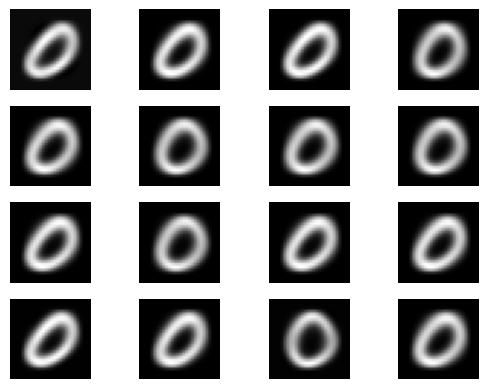

In [4]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def qnode_gen(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):

    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)

    # generating fake feature map
    qml.RX(w000, wires=0)
    qml.RX(w001, wires=1)

    qml.RY(w008, wires=0)
    qml.RY(w009, wires=1)

    qml.RZ(w016, wires=0)
    qml.RZ(w017, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

    qml.RX(w200, wires=0)
    qml.RX(w201, wires=1)

    qml.RY(w208, wires=0)
    qml.RY(w209, wires=1)

    qml.RZ(w216, wires=0)
    qml.RZ(w217, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])


    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1))]

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

# ----------------------------------------------------------------------model-----------------------------------------------------------------------------------
class MNIST_GEN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode_gen, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model_gen = MNIST_GEN().to(device)

model_gen.load_state_dict(torch.load('./2gan_1.pth'))

def test(model, device):
    inputs = torch.empty((16, 2), dtype=torch.float32).uniform_(0.3,0.9)

    outputs = torch.rand((16, 2), device=device)
    for i in range(16):
        outputs[i] = model(inputs[i])*model(inputs[i])
    return outputs


output = test(model_gen, device).detach().numpy()
output = descale_points(output)




new_info = output.reshape(output.shape[0],28,28)
print(f"Epoch {epoch} Generated Images")
for i in range(new_info.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(new_info[i, :, :], cmap='gray')
    plt.axis('off')
plt.savefig("qgan_-epoch-mnist-{}-generated-images".format(epoch))
plt.show()